In [1]:
# imports
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

## Part 1 - Exploratory Data Analysis

In [2]:
# read json to data frame
logins=pd.read_json('logins.json')

In [3]:
# resample logins to 15 min intervals
logins['login_15m']=logins['login_time'].dt.round('15min')
logins=logins.sort_values('login_time')

In [4]:
# aggregate counts over 15 min intervals
counted_logins=logins.groupby('login_15m').count()
# add smoothed line with rolling mean
counted_logins['rollmean']=counted_logins.rolling(4).mean()

In the next block, I plot the time series data aggregated into 15-minute intervals.  The time series is show at 3 levels of detail:  all data, two weeks, and a single day.  The first plot shows smoothed data, the latter plots includes both the smoothed and raw data.  We generally see two peaks in a given day, one mid-day and one in the late evening.  There are higher peaks on weekends, showing more logins during this time.

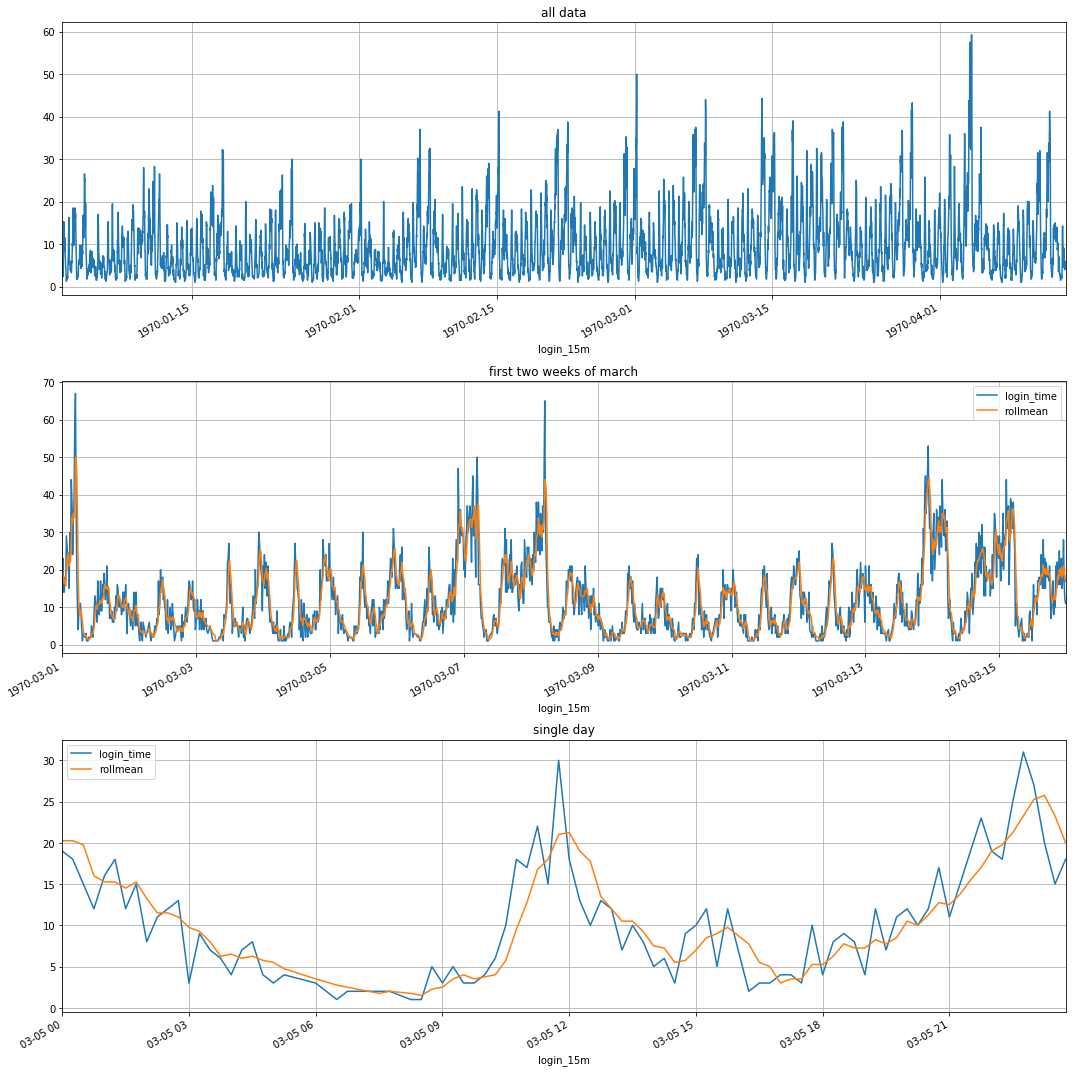

In [5]:
fig,axx=plt.subplots(3,1,figsize=[15,15])
counted_logins['rollmean'].plot(ax=axx[0],title='all data',grid=True)
counted_logins.loc['1970-03-01':'1970-03-15'].plot(ax=axx[1],title='first two weeks of march',grid=True)
counted_logins.loc['1970-03-05'].plot(ax=axx[2],title='single day',grid=True)

plt.tight_layout()

The next plot shows another way of looking at patterns in the data, focusing in on the hourly variation over the course of the average weekday or weekend day.  The dates are ignored, and distributions of login counts are plotted as individual box plots covering 15 minute intervals.  We distinct differences between the weekday and weekend patterns, and more variability in the early morning and late evening hours.  Some of the mid-morning time periods are truncated by zero logins.  The mid-day peak seen in the weekday data is not evident in the weekday data.

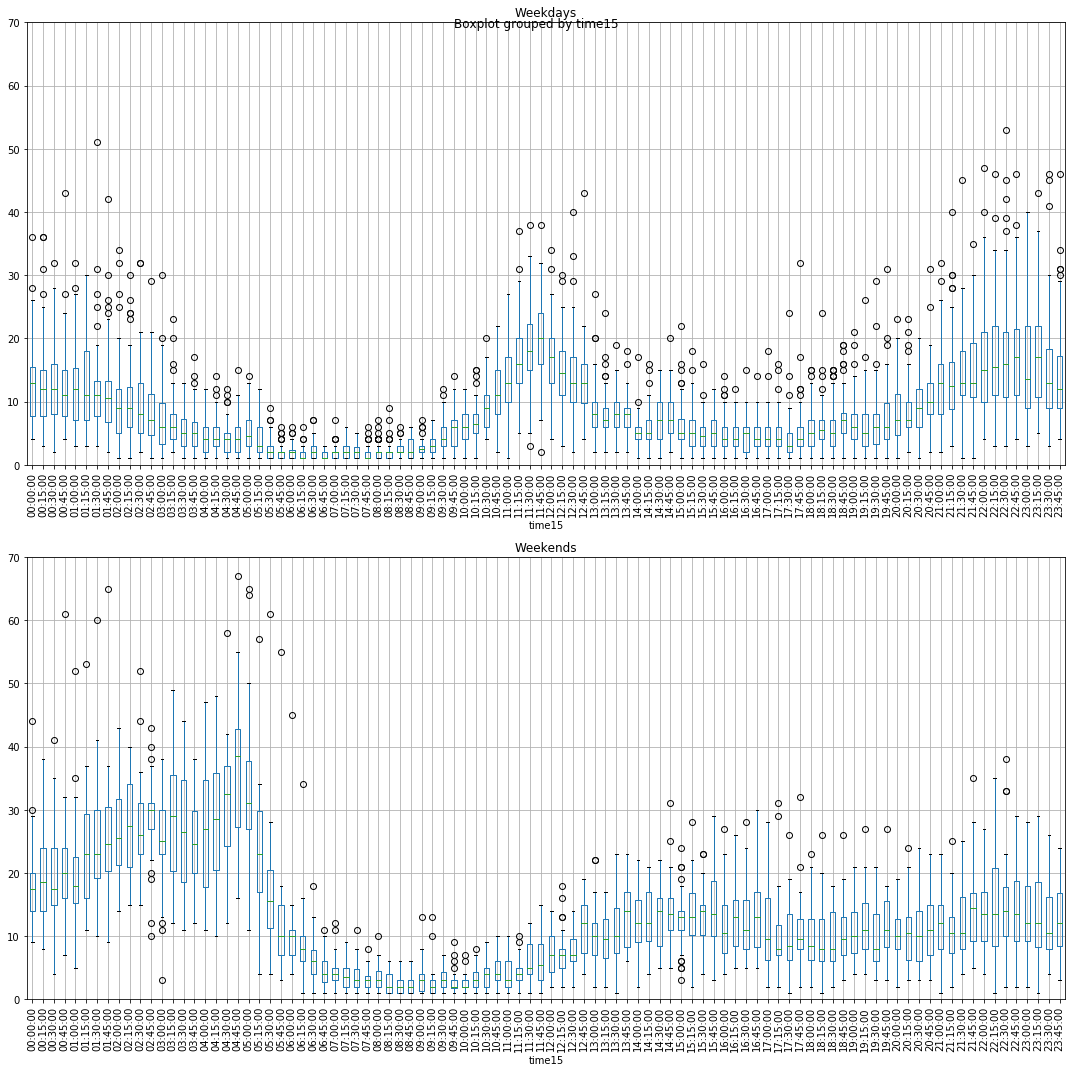

In [6]:
fig,axs=plt.subplots(2,1,figsize=[15,15])
counted_logins['time15']=counted_logins.index.time
counted_logins['dow']=counted_logins.index.dayofweek

counted_logins.loc[counted_logins.dow<5].boxplot('login_time',by='time15',ax=axs[0],rot=90)
counted_logins.loc[counted_logins.dow>=5].boxplot('login_time',by='time15',ax=axs[1],rot=90)
axs[0].set_title('Weekdays')
axs[1].set_title('Weekends')
axs[0].set_ylim([0,70])
axs[1].set_ylim([0,70])

plt.tight_layout()

---
## Part 2 - Experiment and metrics design

The question being asked by the city operations managers is whether the bridge toll acts an impediment to drivers' willingness to operate in the city located across the bridge.  The proposed experiment would offer drivers toll reimbursements in an effort to make them available in both cities.

The key measure of success would be an increase in the proportion of rides provided by drivers in their neighboring city (neighbor proportion).  I selected neighbor proportion because it directly measures the activity of drivers outside their home city.  

Rather than offer reimbursement to all drivers, I would recommend a pilot study where a randomly selected subgroup of drivers from each city would be offered reimbursement (the test group) and another randomly selected group would act as a control.  The groups would be small enough that any increased activity in the test group would be unlikely to affect the control group.  The study would be run over an extended period of time to allow driver activity patterns to reach equilibrium, and to allow for a variety of different market conditions (traffic, weather, holidays, construction, special events, etc).  The advantage of testing a small subgroup is that it is less expensive than testing on the entire driver population. 

The statistical tests I would run would include two-sample tests like:
* Testing for a significant increase in the proportion of rides provided in the neighboring city in the test group before and after reimbursement.
* Testing for a significant increase in the proportion of rides provided in the neighboring city between the test group and control group.

These tests could be implemented as permutation tests, where the data from the test group and control would be combined and resampled many times to generate a distribution of the expected difference in neighbor proportion between the groups under the null hypothesis that reimbursement does not increase the average proportion of rides provided in the neighboring city.  The tests would be interpreted by calculating the proportion of simulated differences greater than the observed difference.  This p-value would be compared to the desired significance level threshold (i.e. 5%), and we would either conclude:  

* There is insufficient evidence that reimbursement of the bridge toll increases neighbor proportion, thus the toll cost was not proven to be an important factor in driver availability in neighboring cities; or
* There is a low probability a chance model would produce this outcome, and thus reimbursement appears to increase the proportion of rides provided in the neighboring city by our test group.  

If the experiment suggested a positive outcome, it would be important to check that the size of the effect was meaningful, and could produce a measurable increase in driver availability.  A caveat is that this experiment was done on a small test group, and not the full driver population. I would recommend that the operations team do additional research to estimate whether there was sufficient rider demand in both city markets for toll reimbursement to not have unintended consequences in the driver pool (like an overabundance of drivers in one city).






---
## Part 3 - Predictive Modelling


In [52]:
with open('ultimate_data_challenge.json') as json_file:
    json_data=json.load(json_file)
ultimate=pd.DataFrame.from_dict(json_data)
ultimate
# --> we see dataset has 50,000 rows and 12 columns

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


### Cleaning steps
To clean the data I would test for null or unusual values in each field.  I would also check that data types for each field were appropriate (such as converting dates from string to datetime).

In [53]:
# Which fields may have null values?
ultimate.info()
# --> need to check avg rating by driver, avg rating of driver, phone 
# --> will handle blank rows in these fields if they turn out to be useful for prediction

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [54]:
# Datetime manipulations to derive the target

# First when was this report run?  Assume its the max date of last trip in the dataset.
ultimate['last_trip_dt']=pd.to_datetime(ultimate.last_trip_date)
maxdate=ultimate.last_trip_dt.max()
ultimate['time_since_last_trip']=maxdate-ultimate['last_trip_dt']

In [55]:
# derive 'active' field:  active if time since last trip <= 30
import datetime
ultimate['active']=np.where(ultimate['time_since_last_trip']<=datetime.timedelta(days=30),1,0)
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_dt,time_since_last_trip,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-17,14 days,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-05-05,57 days,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-01-07,175 days,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-06-29,2 days,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-03-15,108 days,0


In [56]:
# is the active field balanced?
ultimate['active'].value_counts()

0    31196
1    18804
Name: active, dtype: int64

### EDA
Generate visualizations and tables to get a better feel for the data

In [57]:
import seaborn as sns
# list of category and boolean fields
categories=['city', 'phone', 'ultimate_black_user']

# a little cleanup on numeric fields
# first convert percents to fractions
ultimate['weekday_fract']=ultimate.weekday_pct/100
ultimate['surge_fract']=ultimate.surge_pct/100
ultimate=ultimate.drop(['weekday_pct','surge_pct'],axis=1)

numerics=['trips_in_first_30_days',  'avg_rating_of_driver',
       'avg_surge',  'surge_fract', 'weekday_fract', 'avg_dist',
       'avg_rating_by_driver']

In [58]:
# look at summary stats for numeric values
ultimate.groupby('active')[numerics].agg([np.mean,np.std])
# -->the std's are high relative to the means.  

trips_in_first_30_days           avg_rating_of_driver            \
                         mean       std                 mean       std   
active                                                                   
0                    1.658482  2.654222             4.607557  0.664418   
1                    3.306318  4.986743             4.592930  0.542386   

       avg_surge           surge_fract           weekday_fract            \
            mean       std        mean       std          mean       std   
active                                                                     
0       1.075339  0.251361    0.086667  0.221791       0.60647  0.409827   
1       1.073809  0.163170    0.091528  0.155887       0.61389  0.294876   

        avg_dist           avg_rating_by_driver            
            mean       std                 mean       std  
active                                                     
0       6.207939  6.238675             4.787464  0.504648  
1       5.114788  4.615175             4.762772  0.328489

In [59]:
# look at correlations between numeric parameters
ultimate.corr()
# --> the only strong correlation we see is between the related fields surge_fract (fraction of trips with surge >1) and avg_surge (avg surge multiplier over all trips).

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,ultimate_black_user,avg_dist,avg_rating_by_driver,active,weekday_fract,surge_fract
trips_in_first_30_days,1.000000,-0.011302,-0.001841,0.112210,-0.136329,-0.039115,0.210463,0.050388,0.005720
avg_rating_of_driver,-0.011302,1.000000,-0.026189,-0.002086,0.034509,0.123175,-0.011653,0.014630,-0.003899
avg_surge,-0.001841,-0.026189,1.000000,-0.078791,-0.081491,0.010597,-0.003333,-0.110071,0.793582
ultimate_black_user,0.112210,-0.002086,-0.078791,1.000000,0.032310,0.009343,0.205002,0.035998,-0.106861
avg_dist,-0.136329,0.034509,-0.081491,0.032310,1.000000,0.080540,-0.092780,0.101652,-0.104414
avg_rating_by_driver,-0.039115,0.123175,0.010597,0.009343,0.080540,1.000000,-0.026791,0.020442,0.020103
active,0.210463,-0.011653,-0.003333,0.205002,-0.092780,-0.026791,1.000000,0.009693,0.011797
weekday_fract,0.050388,0.014630,-0.110071,0.035998,0.101652,0.020442,0.009693,1.000000,-0.144918
surge_fract,0.005720,-0.003899,0.793582,-0.106861,-0.104414,0.020103,0.011797,-0.144918,1.000000


/Users/rtaylor/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/rtaylor/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/rtaylor/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/rtaylor/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


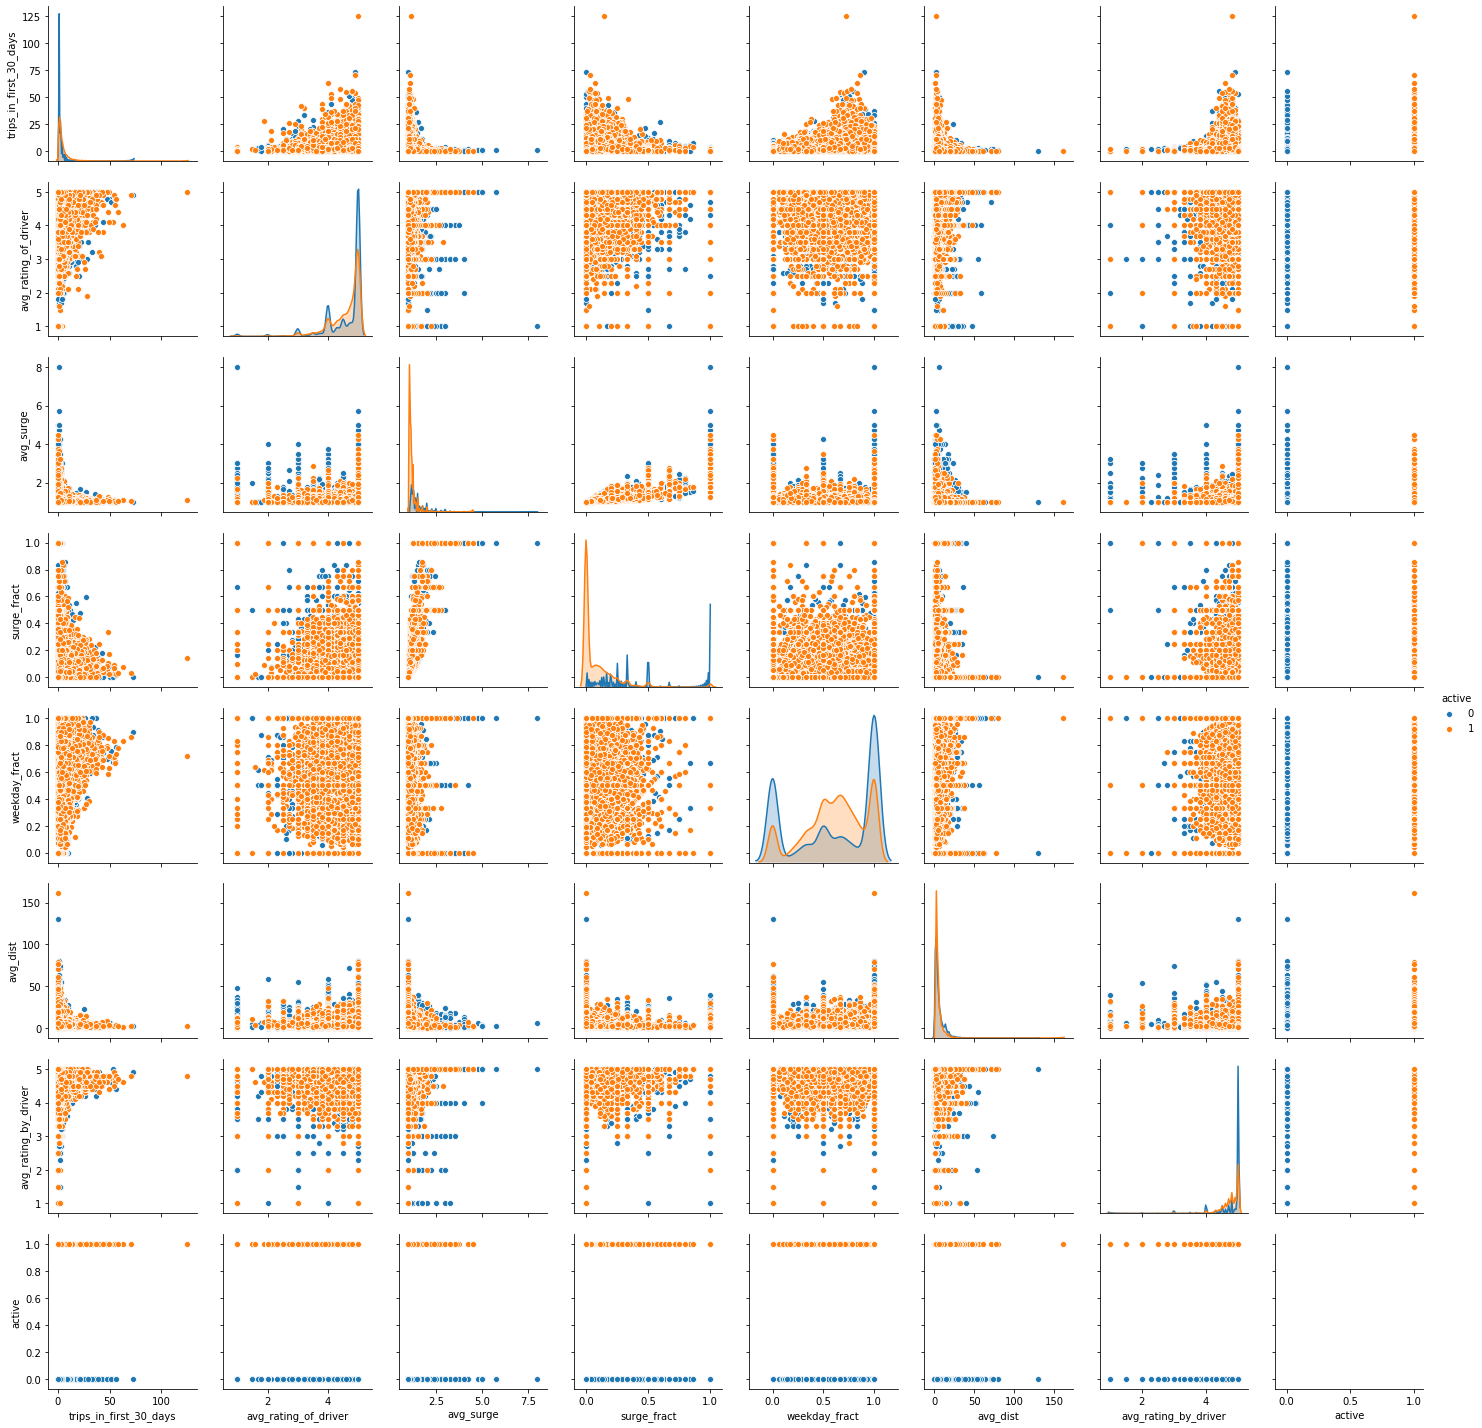

In [60]:
# generate a pairplot to look for correlations between the parameters, the distribution of the parameters 
# between the active/inactive categories (diagonal) and find parameters that may show potential to help predict "active"
to_plot=numerics + ['active']
sns.pairplot(ultimate[to_plot], hue="active")
# --> again avg_surge appears to correlate with surge_fract 
# --> there is something happening with the surge_fract variable (many inactive users with surge_fract=1)
# --> the ratings are biased high  

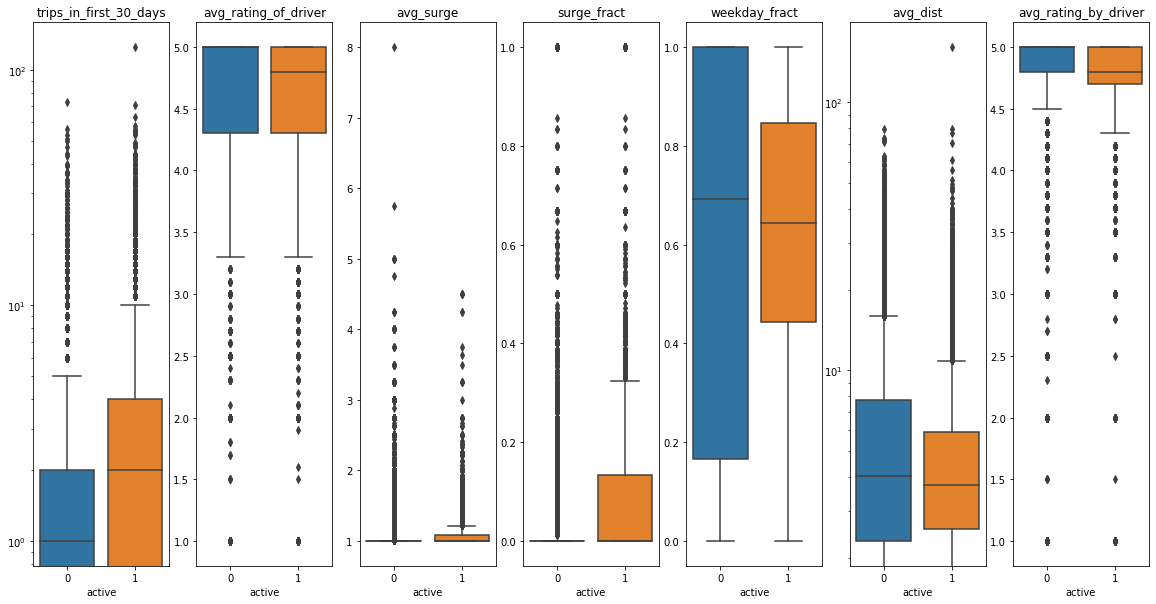

In [180]:
#lets try looking at boxplots of numeric variables comparing active vs inactive
nplots=len(numerics)
fig,axs=plt.subplots(1,nplots,figsize=[20,10])
for p in range(nplots):
    ax=axs[p]
    sns.boxplot(x='active',y=numerics[p],data=ultimate,ax=ax)
    if p in (0,5):
        ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_title(numerics[p])


**Result:**  The distributions of the numeric variables are similar between the two output classes for most predictors.  There are no distinctive patterns distinguishing active from inactive users on the basis of these fields.

Some minor differences between the output classes are seen in the trips_in_first_30_days (skews higher for active),  avg_surge and surge_fract (slightly higher surge usage for active), and the average user/driver ratings (active tends to have lower ratings).

We also see a strange pattern in the weekday fraction, with more inactive users with very low and very high weekday usage, and more active usage in the center with a mixed usage pattern.


In [62]:
# look at categoricals, how do they relate to percent active status?
pd.crosstab(ultimate.ultimate_black_user,ultimate.active)

active,0,1
ultimate_black_user,,
False,21839,9307
True,9357,9497


In [63]:
pd.crosstab(ultimate.city,ultimate.active)

active,0,1
city,,
Astapor,12306,4228
King's Landing,3767,6363
Winterfell,15123,8213


In [64]:
pd.crosstab(ultimate.phone,ultimate.active)

active,0,1
phone,,
Android,11876,3146
iPhone,19057,15525


**Result:** We see a higher proportion of active users in customers using ultimate_black, living in King's Landing, and using iphones.

In [65]:
# derive some new boolean fields from the continous data
ultimate['surge_user']=np.where(ultimate.avg_surge>1.10,1,0)
ultimate['high_surge_fract']=np.where(ultimate.surge_fract>0.1,1,0)


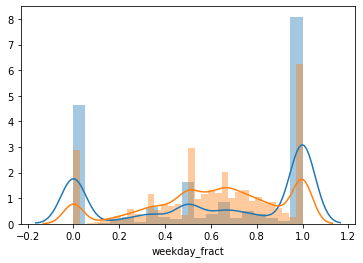

In [66]:
# create a category to divide the weekday usage into multiple usage types

sns.distplot(ultimate.loc[ultimate.active==0,'weekday_fract'])
sns.distplot(ultimate.loc[ultimate.active==1,'weekday_fract'])

wdb=pd.cut(ultimate.weekday_fract,bins=[0.0,0.1,0.5,0.9,1],right=True,include_lowest=True)
ultimate['weekday_binned']=wdb

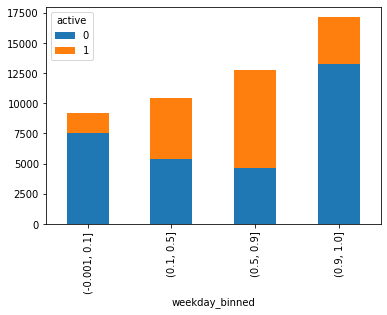

In [95]:
#Visualize if binning helped separate the classes
binned=pd.crosstab(index=ultimate['weekday_binned'],columns=ultimate['active'])
binned.plot.bar(stacked=True)

In [67]:
# rescale number of trips first 30 day to 0-1 scale for LR and KNN classifiers
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
ultimate['first_30_scl']=scaler.fit_transform(ultimate[['trips_in_first_30_days']])

#ultimate[['trips_in_first_30_days','first_30_scl']].sort_values('first_30_scl',ascending=False)

In [68]:
# Null handling:  we won't model on driver/user rating, so those nulls can stay.  Will drop the small number of rows with null phone.
ultimate=ultimate.loc[pd.notnull(ultimate.phone)]

In [74]:
# encode the categoricals and create the data matrix for logistic regression modeling
city_df=pd.get_dummies(ultimate.city,prefix='city',drop_first=False)
phone_df=pd.get_dummies(ultimate.phone,prefix='phone',drop_first=False)
black_df=pd.get_dummies(ultimate.ultimate_black_user,prefix='ultblack',drop_first=False)
week_df=pd.get_dummies(ultimate.weekday_binned,prefix='weekbin',drop_first=False)

X=city_df.join(phone_df).join(black_df).join(week_df).join(ultimate[['surge_user','high_surge_fract','first_30_scl']])
y=ultimate.active
X.head()

,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultblack_False,ultblack_True,"weekbin_(-0.001, 0.1]","weekbin_(0.1, 0.5]","weekbin_(0.5, 0.9]","weekbin_(0.9, 1.0]",surge_user,high_surge_fract,first_30_scl
0,0,1,0,0,1,0,1,0,1,0,0,0,1,0.032
1,1,0,0,1,0,1,0,0,1,0,0,0,0,0.000
2,1,0,0,0,1,1,0,0,0,0,1,0,0,0.024
3,0,1,0,0,1,0,1,0,0,1,0,1,1,0.072
4,0,0,1,1,0,1,0,0,0,1,0,1,1,0.112


## Part 3 - Predictive Modeling

The goal is to build a model to predict rider retention (i.e. active = 1).

My approach:
* divide data into training and test datasets
* build a few out-of-box classifiers. Fit to train, evaluate on test
* select the best model for hyperparameter tuning
* use the final model for prediction of retention

In [233]:
#first lets create the training and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#create empty data frame to hold scores
scores=pd.DataFrame(columns=['model','AUC','accuracy'])

In [234]:
#function to evaluate classifiers
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score,accuracy_score
def evaluate_classifier(classifier,X,y):
    pred_y=classifier.predict(X)
    pred_y_prob = classifier.predict_proba(X)[:,1]
    print(confusion_matrix(y,pred_y))
    print('\n')
    print(classification_report(y,pred_y))
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y, pred_y_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    #output scores as dict
    roc_auc=roc_auc_score(y,pred_y_prob)
    acc=accuracy_score(y,pred_y)
    
    #print auc to screen
    print('AUC: {:.3f}'.format(roc_auc))

    return({'model':type(classifier).__name__,'AUC':roc_auc,'accuracy':acc})

In [235]:
# get the class preponderance 
frac_active=y.sum()/len(y)
print('The overall fraction of active users is: {:.3f}'.format(frac_active))
# --> both classes are fairly common.  Will use default 50% threshold for classification.

The overall fraction of active users is: 0.376


/Users/rtaylor/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[5227 1049]
 [1458 2187]]


              precision    recall  f1-score   support

           0       0.78      0.83      0.81      6276
           1       0.68      0.60      0.64      3645

    accuracy                           0.75      9921
   macro avg       0.73      0.72      0.72      9921
weighted avg       0.74      0.75      0.74      9921



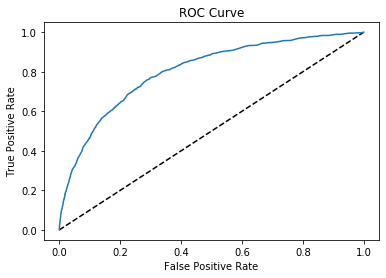

AUC: 0.803


In [236]:
#try out a few out-of-box models on the entire dataset to see if anything is promising.  Fit to train and evaluate on test.
#will tune best model later

#for Logistic regression, need to drop a few one-hot-encoded factors to avoid multi-collinearity

from sklearn.linear_model import LogisticRegression
keepcols=[c for c in X.columns if c not in ('city_Astapor', 'weekbin_(0.1,0.5]','phone_iPhone','ultblack_False','surge_user')]

clf=LogisticRegression(fit_intercept=True,C=0.1).fit(X_train[keepcols],y_train)#C selected by trial and error
out=evaluate_classifier(clf,X_test[keepcols],y_test)
scores=scores.append(out,ignore_index=True)

In [237]:
# interpret coefficients: log odds 

codict=dict(zip(keepcols,np.exp(clf.coef_).tolist()[0]))
codict['intercept']=clf.intercept_[0]
coef_df=pd.DataFrame.from_dict(codict,orient='index',columns=['log_odds_ratio'])
coef_df['odds_ratio']=coef_df['log_odds_ratio'].apply(lambda x:np.exp(x))
coef_df
# --> we see that Kings Landing residents, ultimate black users, 
#    activity in the first 30 days, and weekday usage between 0.5 and 0.9
#    are most associated with higher odds of being active after 6 months.
#    (reference combination is Astapor/iPhone/ultblack_False)

,log_odds_ratio,odds_ratio
city_King's Landing,5.708824,301.516131
city_Winterfell,1.746062,5.731984
phone_Android,0.345563,1.412785
ultblack_True,2.348102,10.465688
"weekbin_(-0.001, 0.1]",0.324308,1.383073
"weekbin_(0.1, 0.5]",1.214090,3.367227
"weekbin_(0.5, 0.9]",2.183897,8.880844
"weekbin_(0.9, 1.0]",0.390483,1.477694
high_surge_fract,1.443515,4.235560
first_30_scl,5.759047,317.045884


[[5077 1199]
 [1377 2268]]


              precision    recall  f1-score   support

           0       0.79      0.81      0.80      6276
           1       0.65      0.62      0.64      3645

    accuracy                           0.74      9921
   macro avg       0.72      0.72      0.72      9921
weighted avg       0.74      0.74      0.74      9921



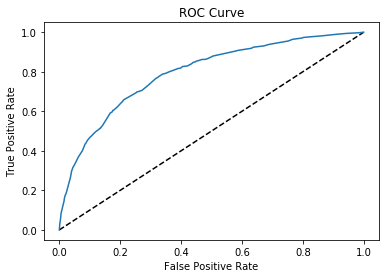

AUC: 0.793


In [238]:
#try naive bayes model, remove last column (continuous, not binary)
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train.iloc[:,:-1],y_train)
out=evaluate_classifier(bnb,X_test.iloc[:,:-1],y_test)
scores=scores.append(out,ignore_index=True)


/Users/rtaylor/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[5208 1068]
 [1447 2198]]


              precision    recall  f1-score   support

           0       0.78      0.83      0.81      6276
           1       0.67      0.60      0.64      3645

    accuracy                           0.75      9921
   macro avg       0.73      0.72      0.72      9921
weighted avg       0.74      0.75      0.74      9921



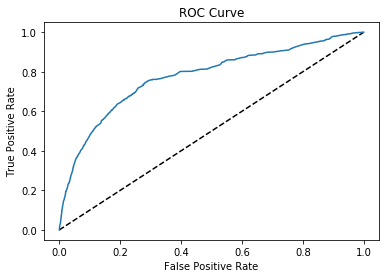

AUC: 0.775


In [239]:
#try SVM (takes a really long time to fit)
from sklearn.svm import SVC
svm=SVC(probability=True)#default SVM uses RBF kernel
svm.fit(X_train,y_train)
out=evaluate_classifier(svm,X_test,y_test)
scores=scores.append(out,ignore_index=True)

In [241]:
#try KNN 
from sklearn.neighbors import KNeighborsClassifier
#first a quick trial of a few different k's

neighbors=[5,10,50,100]
knn_acc=[]
for n in neighbors:
    knn=KNeighborsClassifier(n_neighbors=n)#default 5 neighbors
    knn.fit(X_train,y_train)
    knn_acc.append(knn.score(X_test,y_test))
    
print(dict(zip(neighbors,knn_acc)))
# --> 50 neighbors is the winner

{5: 0.7183751637939724, 10: 0.7431710513053119, 50: 0.7546618284447132, 100: 0.7530490877935692}


[[5270 1006]
 [1428 2217]]


              precision    recall  f1-score   support

           0       0.79      0.84      0.81      6276
           1       0.69      0.61      0.65      3645

    accuracy                           0.75      9921
   macro avg       0.74      0.72      0.73      9921
weighted avg       0.75      0.75      0.75      9921



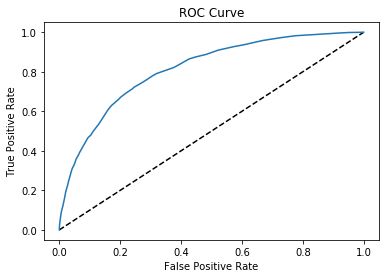

AUC: 0.813


In [242]:
#fit knn with k=50

knn=KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train,y_train)
out=evaluate_classifier(knn,X_test,y_test)
scores=scores.append(out,ignore_index=True)

/Users/rtaylor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[5093 1183]
 [1296 2349]]


              precision    recall  f1-score   support

           0       0.80      0.81      0.80      6276
           1       0.67      0.64      0.65      3645

    accuracy                           0.75      9921
   macro avg       0.73      0.73      0.73      9921
weighted avg       0.75      0.75      0.75      9921



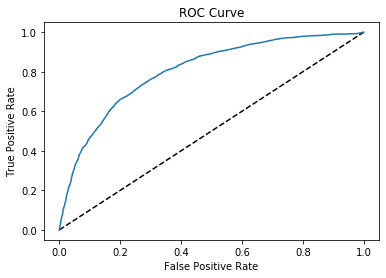

AUC: 0.803
[[5252 1024]
 [1403 2242]]


              precision    recall  f1-score   support

           0       0.79      0.84      0.81      6276
           1       0.69      0.62      0.65      3645

    accuracy                           0.76      9921
   macro avg       0.74      0.73      0.73      9921
weighted avg       0.75      0.76      0.75      9921



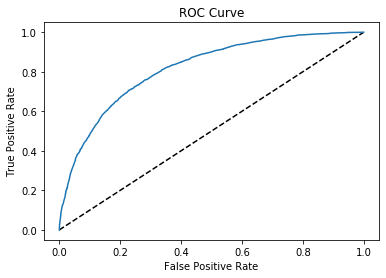

AUC: 0.816


In [243]:
#try nonparametric models
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
out=evaluate_classifier(rfc,X_test,y_test)
scores=scores.append(out,ignore_index=True)

gbc=GradientBoostingClassifier()
gbc.fit(X_train,y_train)
out=evaluate_classifier(gbc,X_test,y_test)
scores=scores.append(out,ignore_index=True)

In [244]:
scores.sort_values('AUC')
#--> All models have similar performance.  Will tune highest scoring (gradient boosting).

,model,AUC,accuracy
2,SVC,0.775439,0.746497
1,BernoulliNB,0.793228,0.740349
0,LogisticRegression,0.802686,0.747304
4,RandomForestClassifier,0.803422,0.750126
3,KNeighborsClassifier,0.812526,0.754662
5,GradientBoostingClassifier,0.816041,0.755367


In [245]:
#fit baseline, print out default settings
gbc0=GradientBoostingClassifier()#default lr=0.1,n_estimators=100,
gbc0.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [246]:
#grid search CV
from sklearn.model_selection import GridSearchCV
params={'learning_rate':[0.05,0.1,0.2,0.3],'min_samples_leaf':[15,20,30],'max_depth':[5,7,9]}#20,7 best combination
    
gbc1=GradientBoostingClassifier(n_estimators=50)#fixed n_estimators lower than default to make training faster
gbc_cv=GridSearchCV(gbc1,params,cv=5)
gbc_cv.fit(X_train,y_train)
y_pred=gbc_cv.predict(X_test)


In [247]:
#gbc_cv.cv_results_

In [248]:
#output best score
gbc_cv.best_score_

0.7619887609303732

In [249]:
#output best parameters
gbc_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 20}

[[5168 1108]
 [1324 2321]]


              precision    recall  f1-score   support

           0       0.80      0.82      0.81      6276
           1       0.68      0.64      0.66      3645

    accuracy                           0.75      9921
   macro avg       0.74      0.73      0.73      9921
weighted avg       0.75      0.75      0.75      9921



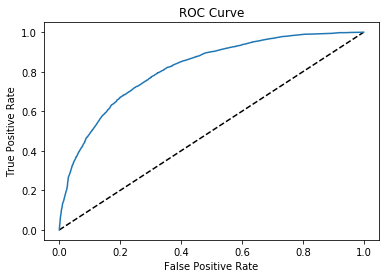

AUC: 0.816


In [250]:
gbc_final=GradientBoostingClassifier(min_samples_leaf=20,max_depth=7,learning_rate=0.1,n_estimators=50)
gbc_final.fit(X_train,y_train)
out=evaluate_classifier(gbc_final,X_test,y_test)

In [251]:
#is this any better than original GB score?  Not really
out

{'model': 'GradientBoostingClassifier',
 'AUC': 0.8158353813294446,
 'accuracy': 0.7548634210261063}

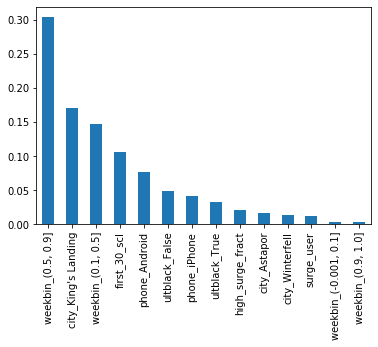

In [252]:
#how to use this? what are important features:
result=pd.Series(index=X_train.columns,data=gbc_final.feature_importances_).sort_values(ascending=False)
result.plot.bar()

## Outcome:

I have built a gradient boosting model that can predict whether a user will be active after 6 months with 75% accuracy.

Factors that turned out to be predictors of retention included the city of residence (with Kings Landing having highest retention), followed by the usage pattern (having mixture of weekday and weekend usage), and having heavier usage in the first 30 days.  The city and 30-day usage parameters were also found to be associated with increased odds of retention in the logistic regression model.

This information could be leveraged by Ultimate to target the two cities associated with lower retention with additional advertising or special offers.  The observation that heavy initial usage was a predictor of retention suggests that offering incentives to take rides immediately after a user signs up may increase their odds of retention.  



